ROI_ecg_fractal_analysis implements functions for determining ECG ROI in order to optimize computational complexity when applying features.

Importing requiered packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import neurokit2 as nk

Get ECG signal lead X for analysis. Next methodology is keeped only for knowledge purposes. Actually its no in used.

In [58]:
with h5py.File('E:/1-DENIS/Biomarkers/SPH dataset/records/A00001.h5', 'r') as f:
    test_signal = f['ecg'][2]

Apply Neurokit ecg_process. In processed variable a dataframe with ECG fiducial points for P-QRS-T waves

In [59]:
processed, _ = nk.ecg_process(test_signal, sampling_rate=500)

Get ECG fiducial points for P-QRS-T waves. From ECG_P_Onsets to ECG_T_Offsets. Additionally ECG_R_Peaks fiducial points are also marked

In [82]:
fid_start = list(processed[processed['ECG_P_Onsets'] == 1].index)
fid_end = list(processed[processed['ECG_T_Offsets'] == 1].index)
fid_r = list(processed[processed['ECG_R_Peaks'] == 1].index)

def create_segments(fiducial_start, fiducial_end), returns initial and final fiducial points implied in ECG ROI (P-QRS-T). This function must be reviewed because P and T waves are not always detected (because its amplitude and the used ECG lead) and differences in P and T segments appear, so pairing initial and final points needs validation

In [84]:
def create_segments(fiducial_start, fiducial_end):
    segments = []
    if len(fiducial_start) > len(fiducial_end):
        index = range(len(fid_start))
        for index, first, second in zip(index, fiducial_start, fiducial_end):
            if (second - first) > 0 and (second - first) <= 400:
                segments.append([first, second])
            else:
                fid_end.insert(index, np.NaN)
    elif len(fid_end) > len(fid_start):
         index = range(len(fid_end))
         for index, first, second in zip(index, fiducial_start, fiducial_end):
            if (second - first) > 0 and (second - first) <= 400:
                segments.append([first, second])
            else:
                fid_start.insert(index, np.NaN)
    else:
        index = range(len(fid_start))
        for index, first, second in zip(index, fiducial_start, fiducial_end):
            if (second - first) > 0 and (second - first) <= 400:
                segments.append([first, second])
            elif (second - first) < 0 and (second - first) <= 400:
                fid_start.insert(index, np.NaN)
            elif (second - first) > 0 and (second - first) > 400:
                fid_end.insert(index, np.NaN)

    return segments

In [85]:
s = create_segments(fid_start, fid_end)

In [86]:
s

[[697, 912], [1941, 2165], [2499, 2673], [3138, 3334], [3731, 4050]]

In [87]:
for first, second in zip(fid_start, fid_end):
    print(second, ' - ' ,first, ' = ' ,second - first)

398  -  nan  =  nan
912  -  697  =  215
nan  -  1267  =  nan
2165  -  1941  =  224
2673  -  2499  =  174
3334  -  3138  =  196
4050  -  3731  =  319
4525  -  4346  =  179


Definitory method: indeed of using P and T fiducial points in order to obtain the ECG ROI, it is simpler to use an interval window of -150 and +150 around the ECG_R_Peaks, in order to simplify computations 

In [2]:
Katz_list = [np.NaN] * 15
with h5py.File('E:/1-DENIS/Biomarkers/SPH dataset/records/A00002.h5', 'r') as f:
    Katz_derivations_dataframe = pd.DataFrame(columns = [c for c in range(15)])
    for der in range (12):
        ecg_sig = f['ecg'][der]
        signals, _ = nk.ecg_process(ecg_sig, sampling_rate=500)
        roi_ref = list(signals[signals['ECG_R_Peaks'] == 1].index)
                    
        for i in range(len(roi_ref)):
            temp, _ = nk.fractal_katz(ecg_sig[roi_ref[i] - 150: roi_ref[i] + 150])
            Katz_list[i] = temp
                    
        Katz_derivations_dataframe.loc[len(Katz_derivations_dataframe)] = Katz_list
        Katz_list = [np.NaN] * 15

Katz_derivations_dataframe.index = [['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']]
Katz_derivations_dataframe.dropna(axis=1, inplace=True)    

Katz_derivations_dataframe in the form leads vs Katz values for obtained ROI's

In [3]:

Katz_derivations_dataframe

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
I,1.245117,1.245117,1.250977,1.249023,1.264648,1.244141,1.237305,1.245117,1.256836,1.241211,1.241211,1.249023,1.245117,1.242188
II,1.205078,1.190430,1.195312,1.201172,1.196289,1.194336,1.190430,1.194336,1.192383,1.191406,1.196289,1.190430,1.194336,1.191406
III,1.280273,1.227539,1.244141,1.263672,1.232422,1.253906,1.251953,1.254883,1.239258,1.246094,1.250977,1.238281,1.238281,1.257812
aVR,1.214844,1.208008,1.211914,1.214844,1.215820,1.208984,1.208008,1.209961,1.205078,1.203125,1.208008,1.208984,1.208008,1.214844
aVL,1.356445,1.359375,1.365234,1.353516,1.446289,1.353516,1.333008,1.344727,1.414062,1.377930,1.337891,1.369141,1.387695,1.338867
aVF,1.209961,1.183594,1.189453,1.201172,1.187500,1.190430,1.191406,1.192383,1.190430,1.188477,1.198242,1.190430,1.190430,1.190430
V1,1.208984,1.186523,1.186523,1.187500,1.184570,1.190430,1.187500,1.192383,1.192383,1.187500,1.195312,1.190430,1.189453,1.189453
V2,1.244141,1.240234,1.236328,1.237305,1.244141,1.231445,1.234375,1.238281,1.236328,1.236328,1.232422,1.236328,1.237305,1.235352
V3,1.355469,1.355469,1.378906,1.378906,1.343750,1.340820,1.367188,1.345703,1.330078,1.361328,1.405273,1.376953,1.409180,1.398438
V4,1.251953,1.244141,1.267578,1.267578,1.264648,1.252930,1.255859,1.256836,1.253906,1.257812,1.250000,1.257812,1.256836,1.267578


Determining best ECG lead based on standard deviation

In [6]:
Katz_derivations_dataframe.std(axis=1).sort_values(ascending=True)

V4     0.005993
V5     0.006021
V6     0.007596
V3     0.011656
V2     0.015221
V1     0.026165
aVR    0.028192
II     0.039433
aVF    0.047513
III    0.052645
I      0.058803
aVL    0.062628
dtype: float64

In [24]:
np.std(Katz_derivations_dataframe, axis=1)

I      0.055786
II     0.037409
III    0.049944
aVR    0.026745
aVL    0.059414
aVF    0.045075
V1     0.024823
V2     0.014440
V3     0.011058
V4     0.005685
V5     0.005712
V6     0.007206
dtype: float64

Generalizing procedure for all normal ECG signals for Katz fractal dimensional feature

In [2]:
normal_ecg_age = pd.read_pickle('normal_ecg_age.pickle')
normal_ecg_age.head()

,ECG_ID,Age,Age_class_0,Age_class_1,Age_class_2,Age_class_3
0,A00002,32,2,1,0,0
1,A00003,63,5,2,1,1
2,A00006,46,3,1,1,0
3,A00008,32,2,1,0,0
4,A00009,48,3,1,1,0


In [4]:
Katz_list = []
std_series = pd.Series([], dtype=float)
Katz_derivations_std_dataframe = pd.DataFrame()
for id in normal_ecg_age['ECG_ID'].iloc:
    print(id)
    with h5py.File(f'E:/1-DENIS/Biomarkers/SPH dataset/records/{id}.h5', 'r') as f:
        for der in range (12):
            ecg_sig = f['ecg'][der]
            signals, _ = nk.ecg_process(ecg_sig, sampling_rate=500)
            roi_ref = list(signals[signals['ECG_R_Peaks'] == 1].index)
                                   
            for i in range(len(roi_ref)):
                temp, _ = nk.fractal_katz(ecg_sig[roi_ref[i] - 150: roi_ref[i] + 150])
                Katz_list.append(temp)
            
            std_series[der] = np.std(Katz_list)
            Katz_list = []
            std_series.name = id           
            
        Katz_derivations_std_dataframe = pd.concat([Katz_derivations_std_dataframe, std_series], axis=1)        
        std_series = pd.Series([], dtype=float)

Katz_derivations_std_dataframe.index = [['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']]

A00002
A00003
A00006
A00008
A00009
A00010
A00012
A00014


c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


A00016
A00017
A00019
A00021


c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret

A00024
A00025


c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


A00026
A00027


c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\YANIBIS\ecg_biomarkers\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


A00028
A00031


KeyboardInterrupt: 

In [50]:
Katz_derivations_std_dataframe

,A00002,A00003,A00006,A00008,A00009,A00010,A00012,A00014,A00016,A00017
I,0.006756,0.092041,0.049438,0.039764,0.012077,0.006809,0.007000,0.032959,0.027542,0.023026
II,0.004120,0.018387,0.034180,0.009041,0.011482,0.003906,0.011902,0.009621,0.007500,0.109863
III,0.013184,0.023636,0.069885,0.013695,0.110046,0.004871,0.027496,0.015083,0.008011,0.048645
aVR,0.003759,0.045776,0.026810,0.007103,0.010544,0.003357,0.007366,0.006924,0.014946,0.017639
aVL,0.030334,0.085876,0.071289,0.028885,0.013382,0.008049,0.011223,0.087280,0.018097,0.033844
aVF,0.006355,0.016495,0.037445,0.009995,0.024582,0.004086,0.081604,0.008728,0.006664,0.081238
V1,0.005783,0.073486,0.021454,0.013000,0.010628,0.003899,0.032654,0.007755,0.023758,0.044525
V2,0.003654,0.012207,0.012939,0.009842,0.021362,0.026505,0.018784,0.009293,0.005981,0.016434
V3,0.023834,0.009888,0.013748,0.014275,0.024719,0.013947,0.015198,0.027359,0.009583,0.013893
V4,0.006866,0.012497,0.005577,0.011703,0.015083,0.010498,0.012093,0.007069,0.038300,0.009903


In [51]:
Katz_derivations_std_dataframe.mean(axis=1).sort_values(ascending=True)

V5     0.012794
V4     0.012955
V2     0.013695
aVR    0.014427
V6     0.014664
V3     0.016647
II     0.022003
V1     0.023712
aVF    0.027740
I      0.029739
III    0.033478
aVL    0.038849
dtype: float16

In [52]:
with h5py.File('E:/1-DENIS/Biomarkers/SPH dataset/records/A00002.h5', 'r') as f:
    ecg_sig = f['ecg'][10]

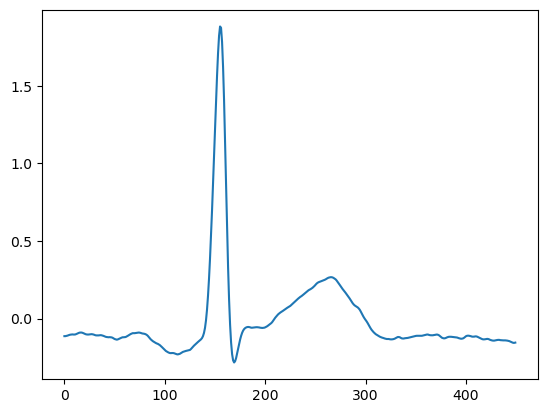

In [56]:
plt.plot(ecg_sig[50:500])